In [1]:
import glob
import os

from dotenv import load_dotenv
# use pip install "labelbox[data]"
from labelbox import Client

from koger_detection.labelbox.annotations import download_annotation_projects
from koger_detection.utils.dataset import scale_annotations_and_images
from koger_detection.utils.dataset import get_bounding_box_areas
from koger_detection.utils.json import alphabetize_categories
from koger_detection.utils.json import combine_jsons
from koger_detection.utils.json import remove_annotation_category

# Load local .env file that contains local path "ROOT" and "LABELBOX_API_KEY"
load_dotenv()

True

In [2]:
os.environ.get("ROOT")

'/home/koger/Projects/bear-hunting'

In [3]:
project_names = ["salmon_confluence_2023"]
# print(*project_names, sep="\n")

research_project = "bear-hunting"
annotation_folder = os.path.join(os.environ.get("ROOT"), "annotations", research_project)

# client = Client(api_key=os.environ.get("LABELBOX_API_KEY"))

In [6]:
# if True:
#     download_annotation_projects(annotation_folder, client, project_names, 
#                                  verbose=True, download_images=True, 
#                                  skip_existing=True)

In [8]:
annotation_folder

'/home/koger/Projects/bear-hunting/annotations/bear-hunting'

## Merge annotations from multiple projects

In [13]:
# High elevation salmon
json_files = glob.glob(os.path.join("/home/koger/Projects/pedro-pond-counts/annotations/pond-counts", "salmon-high-altitude*.json"))
print(f"{len(json_files)} json files found.")

5 json files found.


In [14]:
high_altitude_file = os.path.join(annotation_folder, "high-altitude-combined.json")
combine_jsons(json_files, out_file=high_altitude_file)

There are 325 annotated images with 11175 annotations in the JSON files.
271 images added to new .json
11175 annotations added to new .json


In [15]:
# Survey salmon
json_files = glob.glob(os.path.join("/home/koger/Projects/pedro-pond-counts/annotations/pond-counts", "pond-survey-train*.json"))
print(f"{len(json_files)} json files found.")

survey_file = os.path.join(annotation_folder, "pond-survey-combined.json")
combine_jsons(json_files, out_file=survey_file)

3 json files found.
There are 837 annotated images with 19565 annotations in the JSON files.
729 images added to new .json
19565 annotations added to new .json


In [20]:
import json
from koger_detection.utils.json import rename_categories

In [ ]:
# Add bear class as 1 and salmon as 2
category_mapping = {"salmon-survey": "salmon"}

in_json_file = os.path.join(annotation_folder, "pond-survey-combined.json")
out_json_file = os.path.join(annotation_folder, "pond-survey-combined-with-bear.json")
with open(in_json_file, "r") as read_file:
    json_dict = json.load(read_file)
    
new_coco = rename_categories(json_dict, category_mapping, out_json_file)



In [23]:
# NOTE: Here manually added the bear class to the json

with open(out_json_file, "r") as read_file:
    json_dict = json.load(read_file)

json_dict = alphabetize_categories(json_dict)

with open(out_json_file, "w") as write_file:
    json.dump(json_dict, write_file, indent=4, separators=(',', ': '))

### Resize high altitude annotations to match survey annoations

In [16]:
import json

import matplotlib.pyplot as plt
import numpy as np

High alt median: 612.0
Survey median: 2706.0
Confluence median: 1841.0


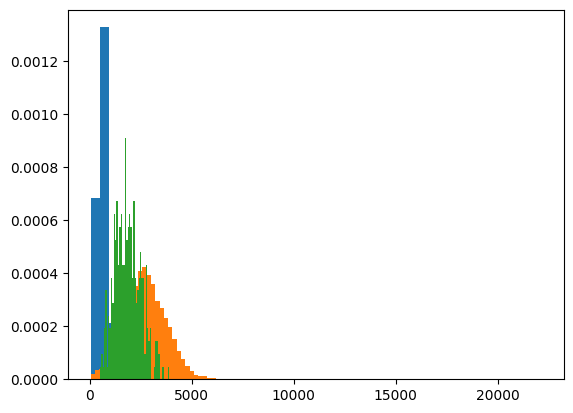

In [24]:
confluence_file = os.path.join(annotation_folder, "salmon_confluence_2023.json")
high_altitude_file = os.path.join(annotation_folder, "high-altitude-combined.json")
survey_file = os.path.join(annotation_folder, "pond-survey-combined-with-bear.json")

# High altitude annotations
with open(high_altitude_file) as f:
    high_altitude_coco = json.load(f)
high_alt_bbox_areas = get_bounding_box_areas(high_altitude_coco)
_ = plt.hist(high_alt_bbox_areas, bins=50, density=True)
high_alt_median = np.median(high_alt_bbox_areas)
print(f"High alt median: {high_alt_median}")

# Survey annotations
with open(survey_file) as f:
    survey_coco = json.load(f)
survey_bbox_areas = get_bounding_box_areas(survey_coco)
_ = plt.hist(survey_bbox_areas, bins=50, density=True)
survey_median = np.median(survey_bbox_areas)
print(f"Survey median: {survey_median}")

# Confluence annotations
with open(confluence_file) as f:
    confluence_coco = json.load(f)
confluence_bbox_areas = get_bounding_box_areas(confluence_coco)
_ = plt.hist(confluence_bbox_areas, bins=50, density=True)
confluence_median = np.median(confluence_bbox_areas)
print(f"Confluence median: {confluence_median}")

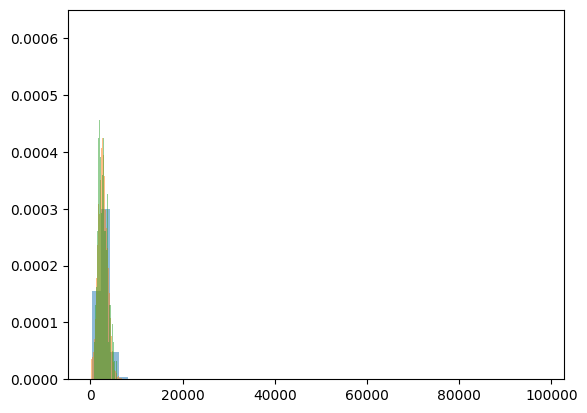

In [25]:

target_median = survey_median
confluence_scale = np.sqrt(target_median / confluence_median)
high_alt_scale = np.sqrt(target_median / high_alt_median)
survey_scale = np.sqrt(target_median / survey_median)

scaled_high_alt_bbox_areas = []
for ann in high_altitude_coco['annotations']:
    area = ann['bbox'][2] * high_alt_scale * ann['bbox'][3] * high_alt_scale
    scaled_high_alt_bbox_areas.append(area)

scaled_survey_areas = []
for ann in survey_coco['annotations']:
    area = ann['bbox'][2] * survey_scale * ann['bbox'][3] * survey_scale
    scaled_survey_areas.append(area)

scaled_confluence_areas = []
for ann in confluence_coco['annotations']:
    area = ann['bbox'][2] * confluence_scale * ann['bbox'][3] * confluence_scale
    scaled_confluence_areas.append(area)

_ = plt.hist(scaled_high_alt_bbox_areas, bins=50, alpha=.5,density=True)
_ = plt.hist(scaled_survey_areas, bins=50, alpha=.5, density=True)
_ = plt.hist(scaled_confluence_areas, bins=50, alpha=.5, density=True)

## Do actual rescaling

In [26]:
images_folder = os.path.join(annotation_folder, "images")
os.makedirs(images_folder, exist_ok=True)
print(f"Images folder: {images_folder}")
scaled_high_alt_json = os.path.join(annotation_folder, f"high-altitude-combined-scaled-{high_alt_scale}.json")
scale_annotations_and_images(high_altitude_coco, high_alt_scale, images_folder, scaled_high_alt_json)

scaled_survey_json = os.path.join(annotation_folder, f"pond-survey-combined-with-bear-scaled-{survey_scale}.json")
scale_annotations_and_images(survey_coco, survey_scale, images_folder, scaled_survey_json)

scaled_confluence_json = os.path.join(annotation_folder, f"confluence-scaled-{confluence_scale}.json")
scale_annotations_and_images(confluence_coco, confluence_scale, images_folder, scaled_confluence_json)

Images folder: /home/koger/Projects/bear-hunting/annotations/bear-hunting/images


## Confirm scaling saved correctly

Confluence median: 2636.5
High alt median: 2640.0
Survey median: 2706.0


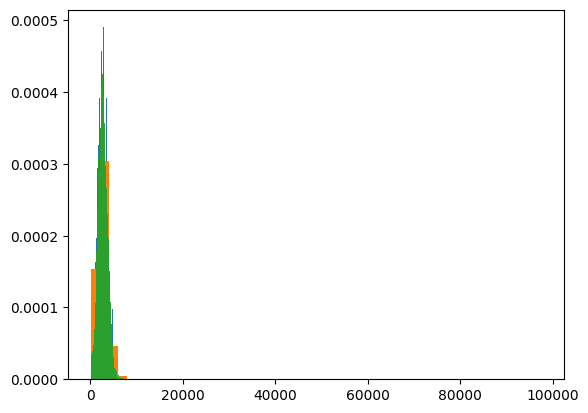

In [27]:

# Confluence annotations
with open(scaled_confluence_json) as f:
    confluence_coco = json.load(f)
confluence_bbox_areas = get_bounding_box_areas(confluence_coco)
_ = plt.hist(confluence_bbox_areas, bins=50, density=True)
confluence_median = np.median(confluence_bbox_areas)
print(f"Confluence median: {confluence_median}")

# High altitude annotations
with open(scaled_high_alt_json) as f:
    high_altitude_coco = json.load(f)
high_alt_bbox_areas = get_bounding_box_areas(high_altitude_coco)
_ = plt.hist(high_alt_bbox_areas, bins=50, density=True)
high_alt_median = np.median(high_alt_bbox_areas)
print(f"High alt median: {high_alt_median}")

# Survey annotations
with open(scaled_survey_json) as f:
    survey_coco = json.load(f)
survey_bbox_areas = get_bounding_box_areas(survey_coco)
_ = plt.hist(survey_bbox_areas, bins=50, density=True)
survey_median = np.median(survey_bbox_areas)
print(f"Survey median: {survey_median}")

### Combine survey and high alt annotations together for the training set (use confluence for val)
    

In [28]:
combine_json_files = [scaled_high_alt_json, scaled_survey_json, scaled_confluence_json]

combined_json = os.path.join(annotation_folder, "scaled-high-altitude-survey-confluence-combined.json")
combine_jsons(combine_json_files, out_file=combined_json)

There are 1007 annotated images with 31046 annotations in the JSON files.
1007 images added to new .json
31046 annotations added to new .json


## Split annotations into train and val set (Not using here for now)

In [29]:
from koger_detection.utils.json import create_train_val_split

In [37]:
# just use the actual pond pictures for validation

In [30]:
json_file = os.path.join(annotation_folder, "scaled-high-altitude-survey-confluence-combined.json")
fraction_val = .15
create_train_val_split(json_file, fraction_val, train_name="train.json", 
                       val_name="val.json")

There are 1007 annotated images.
839 training images with 25983 annotations.
168 validation images with 5063 annotations.


In [44]:
# add all the scaled high-altitude images to the training set
json_files = [os.path.join(annotation_folder, "train.json"),
              os.path.join(annotation_folder, "scaled-high-altitude-combined.json")]
print(f"{len(json_files)} json files found.")

combined_file = os.path.join(annotation_folder, "train-with-high-alt.json")
combine_jsons(json_files, out_file=combined_file)

2 json files found.
There are 543 annotated images with 20583 annotations in the JSON files.
543 images added to new .json
20583 annotations added to new .json


In [14]:
# add all the scaled high-altitude images to the training set
json_files = [os.path.join(annotation_folder, "train-with-high-alt.json"),
              os.path.join(annotation_folder, "pond-survey-train-3.json")]
print(f"{len(json_files)} json files found.")

combined_file = os.path.join(annotation_folder, "train-with-high-alt-low_recall.json")
combine_jsons(json_files, out_file=combined_file)

2 json files found.
There are 851 annotated images with 27558 annotations in the JSON files.
851 images added to new .json
27558 annotations added to new .json


## Bonus: Visualize annotations

In [31]:
import os

import matplotlib.pyplot as plt

import torch
# Note: also need to install pycocotools
from torchvision import datasets
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
import torchvision.transforms.functional as F

In [32]:
example_json = os.path.join(annotation_folder, f"val.json")
image_folder = os.path.join(annotation_folder, "images")

dataset = datasets.CocoDetection(root=image_folder, annFile=example_json)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


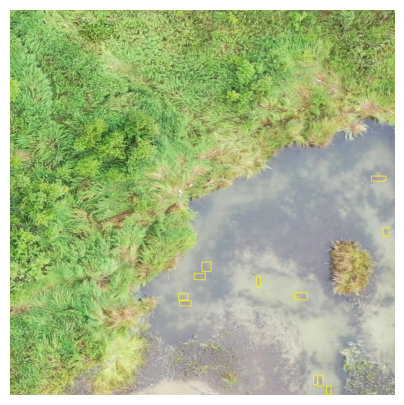

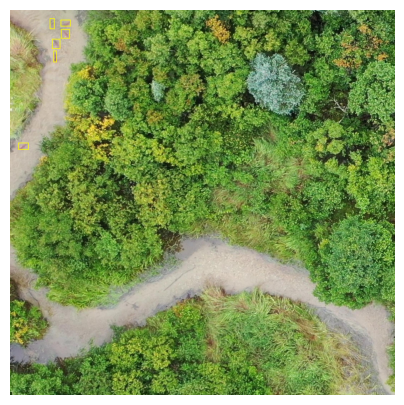

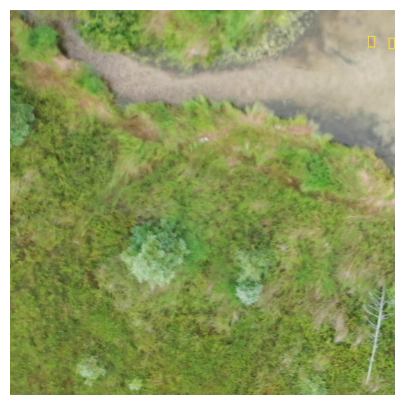

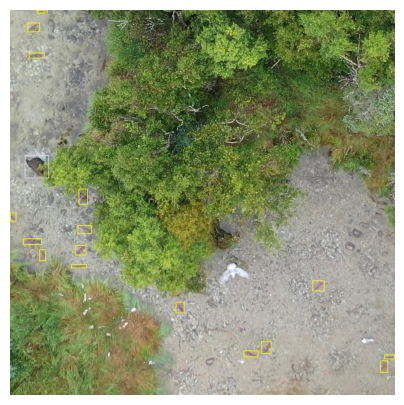

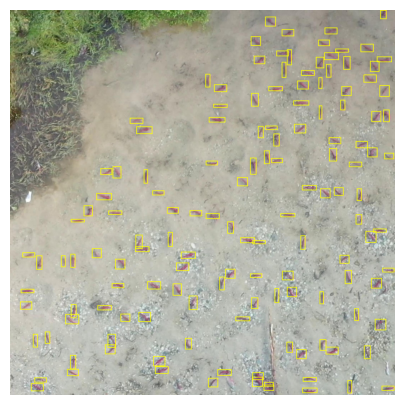

In [33]:
for im_ind in range(0, 5):
    ann = dataset[im_ind]
    if len(ann[1]) >= 1:
        boxes = torch.vstack([box_convert(torch.tensor(a['bbox']), "xywh", "xyxy") for a in ann[1]])
        labels = [a['category_id'] for a in ann[1]]
        colors = [(230,215,255), (255, 255, 0), (255, 0, 255), (255, 155, 0), (255, 0, 155),(255, 155, 155), (255, 255, 155)]
        box_colors = [colors[l-1] for l in labels]
    image = F.pil_to_tensor(ann[0])
    if len(ann[1]) >= 1:
        image = draw_bounding_boxes((image).type(torch.uint8), 
                                      boxes=boxes, colors=box_colors,
                                      width=4)
    else:
        print("No annotations")
    plt.figure(figsize=(5, 5))
    plt.imshow(F.to_pil_image(image))
    plt.axis('off')  